Epoch [1/15], Train Acc: 0.77, Val Acc: 0.96
Epoch [2/15], Train Acc: 0.93, Val Acc: 0.97
Epoch [3/15], Train Acc: 0.96, Val Acc: 0.99
Epoch [4/15], Train Acc: 0.97, Val Acc: 0.99
Epoch [5/15], Train Acc: 0.97, Val Acc: 0.99
Epoch [6/15], Train Acc: 0.98, Val Acc: 0.99
Epoch [7/15], Train Acc: 0.99, Val Acc: 0.99
Epoch [8/15], Train Acc: 0.98, Val Acc: 0.99
Epoch [9/15], Train Acc: 0.98, Val Acc: 0.99
Epoch [10/15], Train Acc: 0.99, Val Acc: 0.98
Epoch [11/15], Train Acc: 0.98, Val Acc: 0.99
Epoch [12/15], Train Acc: 0.98, Val Acc: 0.99
Epoch [13/15], Train Acc: 0.99, Val Acc: 0.98
Epoch [14/15], Train Acc: 0.99, Val Acc: 0.99
Epoch [15/15], Train Acc: 0.99, Val Acc: 1.00

✅ Model saved as 'fruit_veg_model.pth'


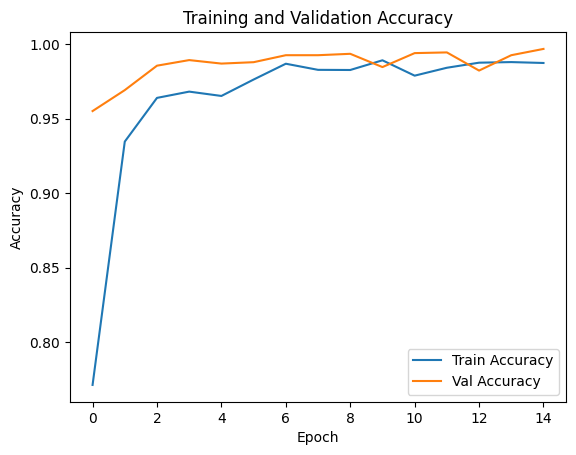

In [1]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Configuration
DATA_DIR = 'D:/DIP-Project/dataset'
BATCH_SIZE = 32
IMG_SIZE = 128
NUM_CLASSES = 20
EPOCHS = 15
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transforms
transform_train = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

transform_test = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# Datasets
train_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, 'train'), transform=transform_train)
val_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, 'val'), transform=transform_test)
test_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, 'test'), transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# Model
class CNNModel(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super(CNNModel, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(128 * (IMG_SIZE // 8) * (IMG_SIZE // 8), 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.model(x)

model = CNNModel().to(DEVICE)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
train_acc_history = []
val_acc_history = []

for epoch in range(EPOCHS):
    model.train()
    total, correct = 0, 0
    for images, labels in train_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_accuracy = correct / total
    train_acc_history.append(train_accuracy)

    # Validation
    model.eval()
    with torch.no_grad():
        total, correct = 0, 0
        for images, labels in val_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        val_accuracy = correct / total
        val_acc_history.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{EPOCHS}], Train Acc: {train_accuracy:.2f}, Val Acc: {val_accuracy:.2f}")

# Save model
torch.save(model.state_dict(), "fruit_veg_model.pth")
print("\n✅ Model saved as 'fruit_veg_model.pth'")

# Plot accuracy
plt.plot(train_acc_history, label='Train Accuracy')
plt.plot(val_acc_history, label='Val Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.show()
